
---
### What is CCT, and why do we use it?

---

**CCT** stands for **Compact Convolutional Transformer**. It is a powerful architecture used in **Computer Vision** problems because it combines the best features of **transformers** and **convolutional neural networks (CNNs)**.

---

##### Key Features of CCT:
- In **Vision Transformer (ViT)**, patches are required. But in **CCT**, the model starts by using **convolutional layers**.
  - These layers extract important features from images, such as **edges** and **textures**.
  - This helps in representing images better and ensures that the model can capture **local patterns** from the image.
  
- After the convolutional layers, **pooling** is required to reshape the images.
  - This reshaped output works as a sequence for the **transformer model**.
  
- **Positional embedding** is usually needed for patches in **ViT**, but in **CCT**, positional embedding is optional.
  - This is because the reshaped image already contains enough information for the transformer encoder.
  
---

##### Transformer Encoder in CCT:

- The **Transformer Encoder** processes the sequence of image tokens (small pieces of the image) and learns how they relate to each other.
- It captures both **local** and **global** patterns in the image.
- The **self-attention** mechanism allows each token to look at every other token in the image and identify the important relationships.
- This helps the model understand how different parts of the image, such as edges and textures, interact.
  
---

##### Sequence Pooling in CCT:

- After the transformer encoder processes the tokens, **Sequence Pooling** gathers information from all tokens and creates a **single, condensed representation** of the entire image.
- The pooled representation is an average (or sum) of all tokens, which is used for classification.
- This step effectively summarizes the whole image into **one vector**, enabling the model to classify the image without needing to focus on individual patches anymore.

---

##### MLP Head in CCT:

- The **MLP Head** (Multilayer Perceptron) is the final part of the model.
  - It takes the pooled representation from sequence pooling and predicts the class of the image (e.g., t-shirt, shoe, etc.).
  - The MLP Head is a simple, fully connected neural network made up of one or more layers of neurons.
  - These neurons process the pooled image representation and output the final prediction, like a 90% chance that the image is a "t-shirt".
  
---

##### Summary:
- **CCT** is particularly effective for **small datasets**, as it uses convolution to extract local features and combines it with transformers to understand **global relationships** within the image.
- This gives it a strong ability to **recognize complex visual patterns**.
- **ViT**, on the other hand, works well with **large datasets**.


![alt text](model_sym.png)

![alt text](comparison.png)

##### Now that we got a grip on CCT basics, we are going to implement CCT on the FashionMnist dataset.

- At First we will import the necessary libraries and load the dataset


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
from torchviz import make_dot
from torchview import draw_graph

In [59]:
# Load the FashionMNIST dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training dataset
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

In [60]:
# Split into training (90%) and validation (10%)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [61]:
# Load the datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [62]:
# Load the test dataset (which is kept aside for evaluation only)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Sample images from the training set:


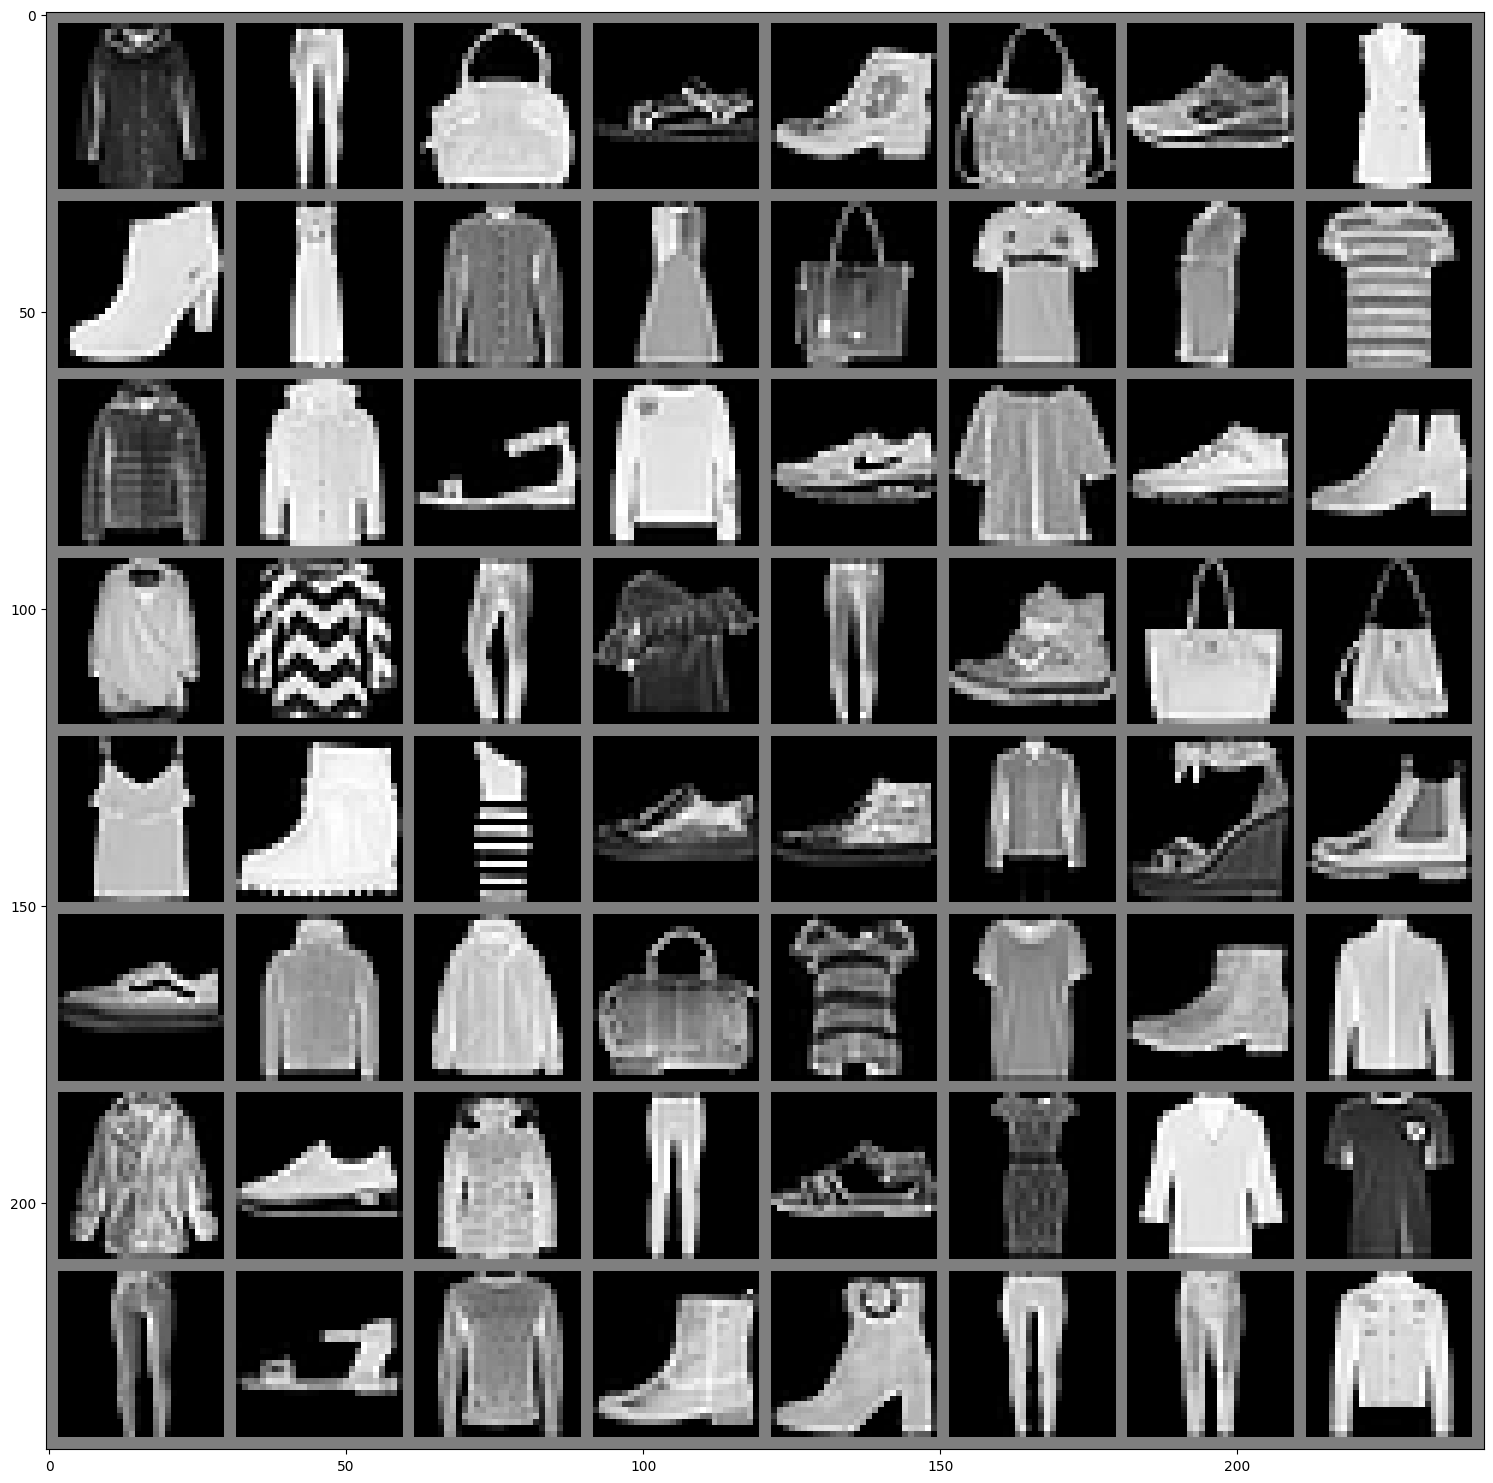

In [63]:
# Get a batch of training data
trainiterator = iter(train_loader)
images, label = trainiterator.next()

# Helper function to display a batch of images

def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.show()

# Show images
print("Sample images from the training set:")
plt.figure(figsize=(15,15))
imshow(make_grid(images))

In [64]:
# Print the shape of the training, validation, and test sets
print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

# Print shape of a single batch of data
print(f"Shape of images batch (training set): {images.shape}")
print(f"Shape of labels batch (training set): {label.shape}")

Training set size: 54000 samples
Validation set size: 6000 samples
Test set size: 10000 samples
Shape of images batch (training set): torch.Size([64, 1, 28, 28])
Shape of labels batch (training set): torch.Size([64])



---

### Detailed Explanation of the **ImprovedTransformerLayer**:

The **ImprovedTransformerLayer** consists of key building blocks that enhance the transformer architecture with multi-head attention, feedforward layers, layer normalization, and residual connections. These components work together to ensure the model can effectively capture relationships within the data while maintaining stability during training. Below is a breakdown of how each component functions:

##### 1. **Multi-head Attention** (`self.attention`):
- **What it does**: 
  - The **multi-head attention mechanism** allows the model to focus on different parts of the input sequence simultaneously. This is crucial for understanding relationships between tokens (image patches, words, etc.) across the entire sequence.
  - **Self-attention** enables each token to attend to all other tokens in the sequence, learning which parts of the sequence are most important for each token. This gives the model the ability to capture both local and global dependencies.

- **Key Parameters**:
  - **`embedding_dim`**: This represents the dimensionality of each token's embedding. It defines the size of the vector that represents each token after the convolutional layers.
  - **`num_heads`**: Multi-head attention splits the attention mechanism into multiple "heads" (parallel attention computations). Each head learns different relationships between tokens, allowing the model to focus on multiple aspects of the data simultaneously. For example, one head might focus on nearby tokens, while another looks at more distant ones.

- **How it works**:
  - The input tensor `x` is passed through the multi-head attention layer, where each token in the sequence can "attend" to every other token. This is done using three matrices: **query**, **key**, and **value**, all derived from the input itself in self-attention.
  - The attention mechanism computes a weighted sum of the values, where the weights are determined by the query-key pairs.
  - The multi-head aspect enables multiple independent attention heads to capture diverse patterns in the data.

---

##### 2. **Residual Connections** and **Layer Normalization**:

- **Residual Connections**:
  - **What it does**: 
    - A **residual connection** adds the original input `x` back to the output of the attention or feed-forward layers. This direct connection helps maintain the original information while also incorporating the new transformations. 
    - Residual connections are crucial in deep models like transformers because they allow **gradients to flow more easily** during backpropagation, reducing the risk of vanishing gradients.
  - **Why it's important**:
    - As models get deeper, there is a risk of information loss or degradation through successive layers. Residual connections help mitigate this issue by ensuring that the original information is preserved.

- **Layer Normalization**:
  - **What it does**:
    - **Layer normalization** is applied after the attention and feedforward operations to stabilize the learning process. It normalizes the input so that it has a mean of 0 and a variance of 1, helping to maintain the stability of activations.
  - **Why it's important**:
    - Without normalization, the model’s activations could become too large or too small, which can slow down learning or cause instability. Normalization ensures that the data flows through the network in a more controlled and stable way, helping the model converge faster and reducing the risk of vanishing/exploding gradients.
  - **When it’s applied**: 
    - Layer normalization is applied **after** the residual connection, ensuring that the combined input and attention output are normalized before passing to the next layer.
  
---

##### 3. **Feedforward Network (FFN)** (`self.ff`):

- **What it does**:
  - The **feedforward network (FFN)** is a two-layer neural network applied independently to each token in the sequence. It helps the model learn more complex, non-linear representations after the attention mechanism.
  
- **How it works**:
  - The FFN consists of:
    1. **Linear Transformation** (`nn.Linear(embedding_dim, ff_dim)`): The first linear layer projects the input (of size `embedding_dim`) to a higher-dimensional space (`ff_dim`), allowing the model to capture more abstract and complex representations of the data.
    2. **ReLU Activation** (`nn.ReLU()`): The ReLU activation introduces non-linearity, allowing the model to learn more complex relationships.
    3. **Second Linear Transformation** (`nn.Linear(ff_dim, embedding_dim)`): The second linear layer projects the data back to the original embedding dimension (`embedding_dim`), ensuring that the output can be processed further or used for residual connections.

- **Why it's important**:
  - The attention mechanism captures relationships between tokens, but the FFN helps the model capture higher-level patterns and enriches the representation of the data.
  - By applying the FFN to each token independently, the model can learn complex transformations for each token in the sequence.
  
---

##### Summary of Improvements in the Transformer Layer:

- **Multi-head attention** allows the model to focus on multiple aspects of the sequence simultaneously, capturing both local and global relationships between tokens.
- **Residual connections** and **layer normalization** help maintain stability, allowing the model to train effectively by keeping gradients flowing and preventing the loss of information.
- The **feedforward network** further transforms the token representations, allowing for more complex pattern recognition in the data.

The **ImprovedTransformerLayer** combines these components to create a powerful, robust, and scalable model block that can be used in deep models for processing sequences such as images (after convolutional tokenization) or text.

---

##### Summary of Improvements in the Transformer Layer:

- **Multi-head attention** allows the model to focus on multiple aspects of the sequence simultaneously, capturing both local and global relationships between tokens.
- **Residual connections** and **layer normalization** help maintain stability, allowing the model to train effectively by keeping gradients flowing and preventing the loss of information.
- The **feedforward network** further transforms the token representations, allowing for more complex pattern recognition in the data.
- **Dropout** is applied throughout the layer to ensure the model is not overfitting, improving generalization to unseen data.

The **ImprovedTransformerLayer** combines these components to create a powerful, robust, and scalable model block that can be used in deep models for processing sequences such as images (after convolutional tokenization) or text.

---

In [82]:
# Improved Transformer Layer without Dropout
class ImprovedTransformerLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.2):
        super(ImprovedTransformerLayer, self).__init__()
        # Multi-head Attention Layer with Layer Normalization
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)
        
        # Feedforward Neural Network without Dropout
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim),
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # Multi-head Self Attention
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output  # Residual connection
        x = self.norm1(x)  # Normalize after attention

        # Feedforward Network
        ff_output = self.ff(x)
        x = x + ff_output  # Residual connection
        x = self.norm2(x)  # Normalize after feedforward

        return x


---

### Now we will build the **Compact Convolutional Transformer (CCT)** model
---

##### 1. **Convolutional Tokenization**:
  - The purpose of convolutional tokenization is to extract local features from the input image. It transforms the input images of size 28x28 into meaningful feature maps that can be processed by the transformer.
  - **In the Image**: The CCT architecture starts with a **Convolutional Tokenization** block, which consists of **4 convolutional layers** with **Dropout** added after each `ReLU` activation. This helps prevent overfitting in the convolutional feature extraction phase.
  - **In the Code**: 
    ```python
    self.conv_layers = nn.Sequential(
        nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(512, embedding_dim, kernel_size=3, padding=1),  # Fourth conv layer with embedding_dim=64
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling the feature map
    )
    ```
  - **Explanation**: The model uses **four convolutional layers** (`nn.Conv2d`) to extract local features from the input image. Each convolutional layer has a **ReLU activation** followed by **Dropout** to regularize and prevent overfitting during training. The final convolutional layer reduces the feature maps to the `embedding_dim=64`, and the output is downsampled using a **MaxPool2d** layer to shrink the spatial dimensions from 28x28 to 14x14.

---

##### 2. **Reshape**:
  - **In the Image**: After the convolutional layers, the output feature maps are reshaped into a sequence that can be processed by the transformer.
  - **In the Code**: 
    ```python
    x = x.view(batch_size, embedding_dim, height * width)  # Shape: [batch_size, embedding_dim, 196]
    x = x.permute(0, 2, 1)  # Shape: [batch_size, 196, embedding_dim]
    ```
  - **Explanation**: The feature maps output by the convolutional layers (with shape `[batch_size, embedding_dim, height, width]`) are flattened into a sequence of **196 tokens** (`14 * 14 = 196`), with each token having a size of `embedding_dim=64`. This prepares the data for processing by the transformer encoder.

---

##### 3. **Positional Embedding** (Optional):
  - **What it does**: Helps the transformer encoder understand the position of each token (patch).
  - **In the Image**: The architecture uses **optional positional embeddings**, which provide positional information about each token in the sequence.
  - **In the Code**:
    ```python
    self.pos_embedding = nn.Parameter(torch.randn(1, (28 // 2)**2, embedding_dim))
    x += self.pos_embedding
    ```
  - **Explanation**: A learnable positional embedding (`self.pos_embedding`) is added to the token sequence. This ensures that the transformer has positional awareness, allowing it to understand where each patch comes from in the image. This is optional but can improve the model's ability to capture spatial relationships.

---

##### 4. **Transformer Encoder**:
  - **What it does**: The transformer encoder models global relationships across the image by processing the token sequence using **multi-head attention** and **feedforward networks**.
  - **In the Image**: The CCT architecture uses **multiple transformer encoder layers** to capture relationships between different parts (tokens) of the image.
  - **In the Code**:
    ```python
    self.transformer_layers = nn.ModuleList([
        ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim, dropout) 
        for _ in range(num_transformer_layers)
    ])
    for layer in self.transformer_layers:
        x = layer(x)
    ```
  - **Explanation**: The model applies **`num_transformer_layers`** transformer layers, each consisting of multi-head attention and feedforward networks (FFN). This helps the model capture both local and global relationships within the image. Unlike the convolutional layers, there is **no dropout** in the transformer layers in this version of the CCT.

---

### Explanation of the **ImprovedTransformerLayer**:

- **Multi-head Attention** (`self.attention`):
  - The **multi-head attention** mechanism allows the model to focus on different parts of the image simultaneously. This enables the model to capture relationships between various tokens (patches) in the image. 
  - **`embedding_dim`** specifies the size of each token embedding, and **`num_heads`** controls how many parallel attention mechanisms are used to capture diverse relationships.
  
- **Residual Connections** and **Layer Normalization**:
  - **Residual connections** add the original input back to the output of the attention and feedforward layers. This stabilizes training by ensuring gradient flow and reducing the risk of vanishing gradients.
  - **Layer normalization** normalizes the output after each operation, ensuring that activations remain stable and preventing the model from becoming unstable during training.

- **Feedforward Network** (`self.ff`):
  - The **feedforward network** consists of two linear transformations with a ReLU activation in between. It projects the input to a higher-dimensional space and back, helping the model learn more complex representations of the data.

---

##### 5. **Sequence Pooling**:
  - **What it does**: Combines the output of the transformer encoder for classification.
  - **In the Image**: The **sequence pooling** layer summarizes the information from the entire sequence (output from the transformer encoder) into a single representation.
  - **In the Code**:
    ```python
    if self.pooling == 'sequence':
      x = x.mean(dim=1)  # Sequence Pooling (average over all tokens)
    ```
  - **Explanation**: In sequence pooling, the outputs of the transformer are averaged across all tokens (`x.mean(dim=1)`). This combined representation of the entire image is then passed to the final classification layer.

---

##### 6. **Linear Layer**:
  - **In the Image**: The final block of the architecture is a **linear layer** that generates the classification output.
  - **In the Code**:
    ```python
    self.fc = nn.Linear(embedding_dim, num_classes)
    x = self.fc(x)
    ```
  - **Explanation**: The model’s final prediction is generated by a fully connected layer (`nn.Linear`), which takes the pooled output from the transformer encoder and maps it to the output classes (10 for FashionMNIST).

---

##### 7. **Classification**:
  - **In the Code**:
    ```python
    x = self.fc(x)
    ```
  - **Explanation**: The fully connected layer produces the final classification by mapping the learned features to the output classes. For FashionMNIST, this corresponds to predicting one of 10 classes (e.g., "t-shirt," "shoe," etc.).

---

### Key Changes:
- **Dropout added in convolutional layers**: Dropout is applied after each **ReLU** activation in the convolutional layers to regularize the feature extraction process and prevent overfitting.
- **No dropout in transformer layers**: The **ImprovedTransformerLayer** focuses on multi-head attention and feedforward networks without dropout.

This explanation includes the detailed workings of the **ImprovedTransformerLayer** and how it fits within the CCT model. It covers the multi-head attention mechanism, feedforward layers, residual connections, and layer normalization in a clear and organized manner. It also explains the changes such as **4 convolutional layers**, **multi-head attention transformer layers**, and advanced techniques like **dropout** and **layer normalization**.


In [83]:
# Compact Convolutional Transformer (CCT) with Dropout in Convolutional Layers
class CCT(nn.Module):
    def __init__(self, input_channels, num_classes, embedding_dim=64, num_heads=4, ff_dim=256, num_transformer_layers=4, dropout=0.2, pooling='sequence'):
        super(CCT, self).__init__()

        # Convolutional layers with Dropout added after ReLU
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(512, embedding_dim, kernel_size=3, padding=1),  # Fourth conv layer with embedding_dim=64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling the feature map
        )
        
        # Positional Embedding (Optional)
        self.pos_embedding = nn.Parameter(torch.randn(1, (28 // 2)**2, embedding_dim))

        # Transformer Encoder Layers
        self.transformer_layers = nn.ModuleList([
            ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim, dropout) 
            for _ in range(num_transformer_layers)
        ])

        # Sequence Pooling or Global Pooling
        self.pooling = pooling
        if self.pooling == 'sequence':
            self.fc = nn.Linear(embedding_dim, num_classes)
        else:
            self.fc = nn.Linear((28 // 2) ** 2 * embedding_dim, num_classes)  # For global pooling

    def forward(self, x):
        # 1. Convolutional Feature Extraction
        x = self.conv_layers(x)  # Shape: [batch_size, embedding_dim, 14, 14]
        batch_size, embedding_dim, height, width = x.shape

        # 2. Flatten and Reshape for Transformer Input
        x = x.view(batch_size, embedding_dim, height * width)  # Shape: [batch_size, embedding_dim, 196]
        x = x.permute(0, 2, 1)  # Shape: [batch_size, 196, embedding_dim]

        # 3. Add Positional Embedding (optional)
        x += self.pos_embedding

        # 4. Transformer Encoder with multiple layers
        for layer in self.transformer_layers:
            x = layer(x)

        # 5. Pooling: Sequence or Global
        if self.pooling == 'sequence':
            x = x.mean(dim=1)  # Sequence Pooling (average over all tokens)
        else:
            x = x.flatten(1)  # Global Pooling (flattening the output)

        # 6. Classification
        x = self.fc(x)  # Shape: [batch_size, num_classes]
        return x


##### Summary of How Code Aligns with the CCT Architecture:

- **Convolutional Tokenization** in the image corresponds to the **convolutional layers** in the code.
- **Reshape** step is handled by reshaping the convolutional output into a token sequence.
- **Positional Embedding** is optional but helps the transformer know the positions of the image patches.
- **Transformer Encoder** is implemented as multiple layers of a transformer encoder to learn global relationships between tokens.
- **Sequence Pooling** averages the output tokens from the transformer, similar to the sequence pooling step in the architecture.
- The final **Linear Layer** classifies the image based on the pooled features.

This alignment ensures the model structure matches the CCT architecture you shared. Let me know if you need further clarification!

### Model Visualization

In [75]:
# Get a real sample from the dataset
images, labels = next(iter(test_loader))

# Move the data to the appropriate device (GPU or CPU)
images = images.to(device)

# Forward pass through the model using the real FashionMNIST data
output = model(images)

# Create a graph of the model using real input
model_graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph to a PNG file
model_graph.render("model_cct_fashionmnist_architecture", format="png")


'model_cct_fashionmnist_architecture.png'


(dot.exe:13716): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:21528): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


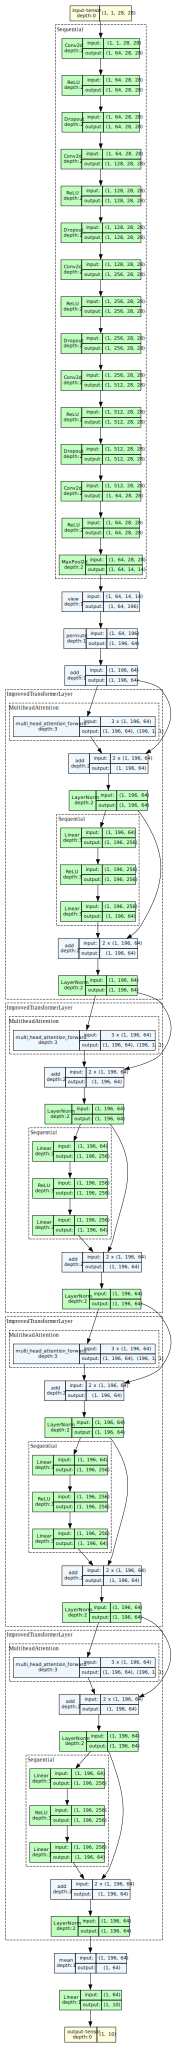

In [76]:
images, labels = next(iter(test_loader))

# Move the data to the appropriate device (GPU or CPU)
images = images.to(device)

# Visualize the model using torchview
graph = draw_graph(model, input_size=(1, 1, 28, 28), device=device, expand_nested=True, save_graph = True)

# Save the graph to a file
graph.visual_graph

In [77]:
torch.onnx.export(model, images, "cct_model_fashionmnist.onnx", input_names=["input"], output_names=["output"], export_params=True)

In [78]:
# Model must be on the device (GPU or CPU)
model.to(device)

# Show the model summary
summary(model, input_size=(1, 28, 28))  # Input size for a grayscale image (like FashionMNIST)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
           Dropout-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
              ReLU-5          [-1, 128, 28, 28]               0
           Dropout-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
              ReLU-8          [-1, 256, 28, 28]               0
           Dropout-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
          Dropout-12          [-1, 512, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]         294,976
             ReLU-14           [-1, 64,

### Model Training

In [79]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
# # Initialize model, loss function and optimizer
# model = CCT(input_channels=1, num_classes=10).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     # Training Phase
#     model.train()
#     total_loss = 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()

#     # Validation Phase
#     model.eval()
#     total_val_loss = 0
#     correct, total = 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             total_val_loss += loss.item()

#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     val_accuracy = 100 * correct / total
#     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {total_val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [84]:
# Initialize lists to store the training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0  # For training accuracy
    
    # Progress bar with tqdm for training phase
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Update progress bar
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_accuracy = 100 * correct_train / total_train  # Training accuracy
    
    # Store training loss and accuracy
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0  # For validation accuracy
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val  # Validation accuracy
    
    # Store validation loss and accuracy
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Print training and validation results for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {total_val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Early Stopping & Model Saving
    avg_val_loss = total_val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset early stopping counter if improvement
        print("Validation loss improved. Saving model weights...")
        torch.save(model.state_dict(), checkpoint_path)  # Save the best model
    else:
        early_stop_counter += 1  # Increment early stopping counter
    
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break  # Stop training if no improvement for 'patience' epochs

# After training is complete, load the best model weights
print("Loading the best model weights from saved checkpoint...")
model.load_state_dict(torch.load(checkpoint_path))


Epoch [1/30], Training Loss: 0.8437, Training Accuracy: 68.57%, Validation Loss: 0.4328, Validation Accuracy: 84.32%
Validation loss improved. Saving model weights...


Epoch [2/30], Training Loss: 0.3856, Training Accuracy: 86.05%, Validation Loss: 0.3426, Validation Accuracy: 87.70%
Validation loss improved. Saving model weights...


Epoch [3/30], Training Loss: 0.3176, Training Accuracy: 88.55%, Validation Loss: 0.2703, Validation Accuracy: 90.27%
Validation loss improved. Saving model weights...


Epoch [4/30], Training Loss: 0.2827, Training Accuracy: 89.90%, Validation Loss: 0.2688, Validation Accuracy: 90.18%
Validation loss improved. Saving model weights...


Epoch [5/30], Training Loss: 0.2565, Training Accuracy: 90.88%, Validation Loss: 0.2399, Validation Accuracy: 91.72%
Validation loss improved. Saving model weights...


Epoch [6/30], Training Loss: 0.2407, Training Accuracy: 91.44%, Validation Loss: 0.2340, Validation Accuracy: 91.88%
Validation loss improved. Saving model weights...


Epoch [7/30], Training Loss: 0.2262, Training Accuracy: 91.93%, Validation Loss: 0.2275, Validation Accuracy: 92.02%
Validation loss improved. Saving model weights...


Epoch [8/30], Training Loss: 0.2157, Training Accuracy: 92.09%, Validation Loss: 0.2244, Validation Accuracy: 92.12%
Validation loss improved. Saving model weights...


Epoch [9/30], Training Loss: 0.2061, Training Accuracy: 92.60%, Validation Loss: 0.2279, Validation Accuracy: 92.08%


Epoch [10/30], Training Loss: 0.2001, Training Accuracy: 92.81%, Validation Loss: 0.2213, Validation Accuracy: 92.43%
Validation loss improved. Saving model weights...


Epoch [11/30], Training Loss: 0.1904, Training Accuracy: 93.13%, Validation Loss: 0.2000, Validation Accuracy: 93.40%
Validation loss improved. Saving model weights...


Epoch [12/30], Training Loss: 0.1833, Training Accuracy: 93.45%, Validation Loss: 0.2112, Validation Accuracy: 92.90%


Epoch [13/30], Training Loss: 0.1780, Training Accuracy: 93.61%, Validation Loss: 0.2119, Validation Accuracy: 92.53%


Epoch [14/30], Training Loss: 0.1729, Training Accuracy: 93.68%, Validation Loss: 0.2043, Validation Accuracy: 92.88%


Epoch [15/30], Training Loss: 0.1683, Training Accuracy: 93.95%, Validation Loss: 0.1995, Validation Accuracy: 93.05%
Validation loss improved. Saving model weights...


Epoch [16/30], Training Loss: 0.1647, Training Accuracy: 94.05%, Validation Loss: 0.1901, Validation Accuracy: 93.67%
Validation loss improved. Saving model weights...


Epoch [17/30], Training Loss: 0.1628, Training Accuracy: 94.14%, Validation Loss: 0.1971, Validation Accuracy: 93.38%


Epoch [18/30], Training Loss: 0.1574, Training Accuracy: 94.31%, Validation Loss: 0.1946, Validation Accuracy: 93.55%


Epoch [19/30], Training Loss: 0.1571, Training Accuracy: 94.25%, Validation Loss: 0.1936, Validation Accuracy: 93.55%


Epoch [20/30], Training Loss: 0.1545, Training Accuracy: 94.37%, Validation Loss: 0.1910, Validation Accuracy: 93.30%


Epoch [21/30], Training Loss: 0.1509, Training Accuracy: 94.55%, Validation Loss: 0.1929, Validation Accuracy: 93.73%
Early stopping triggered after 5 epochs with no improvement.
Loading the best model weights from saved checkpoint...


<All keys matched successfully>

##### **Explanation**:
- **Training Loop**: We loop through the dataset, perform a forward pass, compute the loss, and then perform backpropagation to update model weights.
- **Loss**: We use CrossEntropyLoss as it’s suitable for classification problems.
- **Optimizer**: We use Adam optimizer for its efficiency in convergence.

##### Accuracy and Loss Plot

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.show()

### Model Evaluation

In [85]:
# Test the model on unseen test data
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy on unseen data: {test_accuracy:.2f}%')


Test Accuracy on unseen data: 92.39%
